In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Configurar estilo de Seaborn
sns.set_theme(style="darkgrid")

# Ruta al archivo de periodograma (ajustar según tu archivo)
archivo_periodograma = "periodogramas/datos1_periodograma.csv"

# Cargar los datos del archivo
periodograma = pd.read_csv(archivo_periodograma)

# Calcular los períodos en minutos
periodograma['periodo'] = 1 / periodograma['frecuencia']

# Crear la gráfica
plt.figure(figsize=(12, 6))
sns.lineplot(
    x=periodograma['periodo'], 
    y=periodograma['potencia'], 
    color='blue', 
    linewidth=2, 
    label="Potencia"
)

# Etiquetas y título
plt.xlabel("Período (minutos)", fontsize=14)
plt.ylabel("Potencia", fontsize=14)
plt.title("Periodograma de Lomb-Scargle", fontsize=16)

# Ajustar los ticks del eje x
plt.xticks(
    np.linspace(periodograma['periodo'].min(), periodograma['periodo'].max(), 10), 
    rotation=45, 
    fontsize=12
)

# Agregar leyenda
plt.legend(loc="upper right", fontsize=12)

# Mostrar gráfica
plt.tight_layout()  # Ajusta el diseño para evitar cortes
plt.show()

# Paralelizar el cálculo
num_cores = cpu_count() - 1
with Pool(processes=num_cores) as pool:
    resultados = pool.map(calcular_periodograma, lista_archivos)

# Guardar los resultados generales
output_file = "resultados.txt"
resumen_file = "resumen.txt"

output_data = pd.DataFrame({
    'archivo': [res['archivo'] for res in resultados],
    'periodicidad_maxima_minutos': [
        res['periodo_maximo'] if res['mensaje'] is None else "NA" for res in resultados
    ],
    'poder_maximo': [
        res['poder_maximo'] if res['mensaje'] is None else "NA" for res in resultados
    ],
    'intervalo_confianza': [
        res['intervalo_confianza'] if res['mensaje'] is None else "NA" for res in resultados
    ],
    'significativo': [
        res['significativo'] if res['mensaje'] is None else "NA" for res in resultados
    ]
})

output_data.to_csv(output_file, sep='\t', index=False, header=True)

# Generar el resumen
resumen_lines = []
for res in resultados:
    if res['mensaje'] is None:
        resumen_lines.append(
            f"Archivo: {res['archivo']}\n"
            f"  Período Máximo: {res['periodo_maximo']:.2f} minutos\n"
            f"  Poder Máximo: {res['poder_maximo']:.4f}\n"
            f"  Intervalo de Confianza: {res['intervalo_confianza']}\n"
            f"  Significativo: {'Sí' if res['significativo'] else 'No'}\n"
        )
    else:
        resumen_lines.append(f"Archivo: {res['archivo']}\n  Error: {res['mensaje']}\n")

with open(resumen_file, "w") as resumen:
    resumen.write("\n".join(resumen_lines))


In [ ]:
#!/usr/bin/env python

import pandas as pd
import numpy as np
from scipy.signal import lombscargle
from multiprocessing import Pool, cpu_count
import os

# Crear la carpeta para guardar los periodogramas
os.makedirs("periodogramas", exist_ok=True)

# Función para calcular el periodograma con intervalo de confianza mediante bootstrap
def calcular_periodograma(archivo, n_bootstrap=1000, confidence_level=0.95):
    resultado = {
        'archivo': archivo,
        'mensaje': None,
        'periodo_maximo': np.nan,
        'poder_maximo': np.nan,
        'intervalo_periodo': None,
        'significativo': False,
        'frecuencias': None,
        'potencias': None
    }

    # Leer los datos del archivo
    try:
        data = pd.read_csv(archivo, header=None, sep=r'\s+')
    except Exception as e:
        resultado['mensaje'] = f"Error al leer el archivo: {e}"
        return resultado

    # Transformar las fechas
    data.iloc[:, 0] -= data.iloc[:, 0].min()
    data.iloc[:, 0] *= 24 * 60  # Convertir a minutos
    data.iloc[:, 1] *= 10**8  # Escalar el flujo
    data = data.dropna()  # Eliminar NaNs

    if len(data) == 0 or data.iloc[:, 1].var() == 0:
        resultado['mensaje'] = "Datos insuficientes o constantes."
        return resultado

    # Calcular el periodograma de Lomb-Scargle
    try:
        time = data.iloc[:, 0].values
        flux = data.iloc[:, 1].values

        # Rango de períodos (50 a 200 minutos)
        frequency = np.linspace(1 / 150, 1 / 50, 1000)
        angular_frequency = 2 * np.pi * frequency

        power = lombscargle(time, flux, angular_frequency)

        # Guardar las frecuencias y potencias para graficar
        resultado['frecuencias'] = frequency
        resultado['potencias'] = power

        # Máximo valor del periodograma
        max_index = np.argmax(power)
        periodo_maximo = 1 / frequency[max_index]
        poder_maximo = power[max_index]

        # Bootstrap para calcular el intervalo de confianza del período
        bootstrap_periods = []
        for _ in range(n_bootstrap):
            # Resamplear los datos con reemplazo
            indices = np.random.choice(len(time), len(time), replace=True)
            resampled_time = time[indices]
            resampled_flux = flux[indices]

            # Calcular el periodograma para el conjunto resampleado
            resampled_power = lombscargle(resampled_time, resampled_flux, angular_frequency)

            # Obtener el período máximo del resampleo
            resampled_max_index = np.argmax(resampled_power)
            resampled_period = 1 / frequency[resampled_max_index]
            bootstrap_periods.append(resampled_period)

        # Calcular el intervalo de confianza
        lower_bound = np.percentile(bootstrap_periods, (1 - confidence_level) / 2 * 100)
        upper_bound = np.percentile(bootstrap_periods, (1 + confidence_level) / 2 * 100)
        intervalo_periodo = (lower_bound, upper_bound)

        # Significancia estadística
        global_threshold = np.mean(power) + 2 * np.std(power)
        significativo = poder_maximo > global_threshold

        # Actualizar resultados
        resultado.update({
            'periodo_maximo': periodo_maximo,
            'poder_maximo': poder_maximo,
            'intervalo_periodo': intervalo_periodo,
            'significativo': significativo
        })

        # Guardar los datos del periodograma en un archivo
        periodograma_file = f"periodogramas/{os.path.basename(archivo).split('.')[0]}_periodograma.csv"
        pd.DataFrame({'frecuencia': frequency, 'potencia': power}).to_csv(
            periodograma_file, index=False
        )

    except Exception as e:
        resultado['mensaje'] = str(e)

    return resultado
# Leer la lista de archivos
with open("lista.txt", "r") as file:
    lista_archivos = [line.strip() for line in file.readlines()]

# Paralelizar el cálculo
num_cores = cpu_count() - 1
with Pool(processes=num_cores) as pool:
    resultados = pool.map(calcular_periodograma, lista_archivos)

# Guardar los resultados generales
output_file = "resultados.txt"
resumen_file = "resumen.txt"

output_data = pd.DataFrame({
    'archivo': [res['archivo'] for res in resultados],
    'periodicidad_maxima_minutos': [
        res['periodo_maximo'] if res['mensaje'] is None else "NA" for res in resultados
    ],
    'poder_maximo': [
        res['poder_maximo'] if res['mensaje'] is None else "NA" for res in resultados
    ],
    'intervalo_periodo': [
        res['intervalo_periodo'] if res['mensaje'] is None else "NA" for res in resultados
    ],
    'significativo': [
        res['significativo'] if res['mensaje'] is None else "NA" for res in resultados
    ]
})

output_data.to_csv(output_file, sep='\t', index=False, header=True)

# Generar el resumen
resumen_lines = []
for res in resultados:
    if res['mensaje'] is None:
        resumen_lines.append(
            f"Archivo: {res['archivo']}\n"
            f"  Período Máximo: {res['periodo_maximo']:.2f} minutos\n"
            f"  Intervalo del Período: {res['intervalo_periodo']}\n"
            f"  Poder Máximo: {res['poder_maximo']:.4f}\n"
            f"  Significativo: {'Sí' if res['significativo'] else 'No'}\n"
        )
    else:
        resumen_lines.append(f"Archivo: {res['archivo']}\n  Error: {res['mensaje']}\n")

with open(resumen_file, "w") as resumen:
    resumen.write("\n".join(resumen_lines))


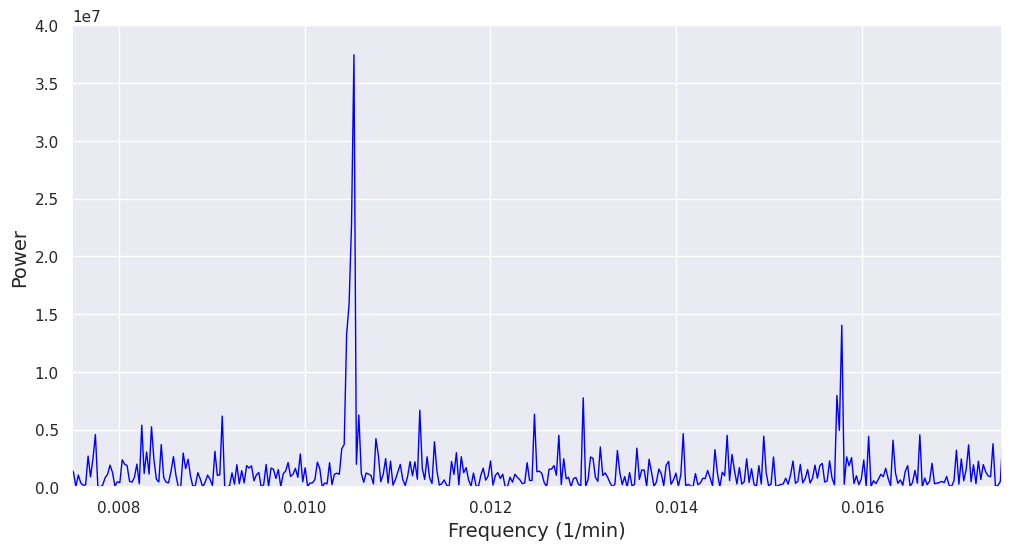

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Configurar estilo de Seaborn
sns.set_theme(style="darkgrid")

# Ruta al archivo de periodograma (ajustar según tu archivo)
archivo_periodograma = "sagA-clean-gamma_periodograma.csv"

# Cargar los datos del archivo
periodograma = pd.read_csv(archivo_periodograma)

# Crear la gráfica
plt.figure(figsize=(12, 6))
sns.lineplot(
    x=periodograma['frecuencia'], 
    y=periodograma['potencia'], 
    color='blue', 
    linewidth=1, 
 #   label="Potencia"
)

# Etiquetas y título
plt.xlabel("Frequency (1/min)", fontsize=14)
plt.ylabel("Power", fontsize=14)
#plt.title("Periodograma de Lomb-Scargle", fontsize=16)
plt.xlim(0.0075,0.0175)
plt.ylim(0,4e7)
# Agregar leyenda
# plt.legend(loc="upper right", fontsize=12)

plt.savefig("images/lombScargle_periodogram_serie_1.png", format='png', dpi=300)
# Mostrar gráfica
plt.show()
